In [1]:
import json
from pathlib import Path
import pandas as pd
import pyarrow as pa
from tqdm import tqdm
import pyarrow.parquet as pq

In [5]:
hashes = json.load(open(Path("../data/digests/benchmark-datasets-full/benchmark-datasets-full_tally.json"), "r"))

In [7]:
src_dir = Path("../data/benchmark-datasets-full")
dest_dir = Path("../data/benchmark-datasets-dedup/")

I label as `true_duplicates` those hashes that have different dataset ID, but the same md5. It's very likely that they 
contain the same data, but it doesn't hurt to make sure that's the case. 

In [56]:
true_duplicates = {}

In [77]:
for hash, path_list in hashes.items():
    # print(hash)
    # print(len(path_list))
    
    if len(set((Path(pth).parts[-3] for pth in path_list))) > 1:
        print(set([Path(pth).parts[-3] for pth in path_list]))
        true_duplicates[hash] = path_list

{'datamart.socrata.www-data-act-gov-au.65z9-5mfa', 'datamart.socrata.www-data-act-gov-au.wpfn-nze5'}
{'datamart.upload.d2f343829a3a45db80e360488714a47e', 'datamart.upload.43c9b371744148ca85193b3b8784816f'}
{'datamart.url.e8ad58ccedbd437b96f4a36de3f4f8a7', 'datamart.url.2c01b1f81d655c85a55e5dfeb2f6d9f8'}
{'datamart.zenodo.6537414.60446bd0-2fed-4c5c-a738-b1a34bf3303c', 'datamart.zenodo.6537414.c0e9c97a-f337-4090-a281-5f1fd280a2ee'}
{'datamart.socrata.data-ct-gov.rybz-nyjw', 'datamart.url.46f0a09b4ba24878a346b652485ece58'}
{'datamart.socrata.data-usaid-gov.nvx5-5f2f', 'datamart.socrata.data-usaid-gov.h8u5-uvnp'}
{'datamart.url.b506c035e4195262aabc94926ab16602', 'datamart.upload.51f8be1b95504bc5b9d333209f6521ac'}
{'datamart.socrata.opendata-utah-gov.rti9-2cf2', 'datamart.socrata.opendata-utah-gov.t8xs-7rpm'}
{'datamart.socrata.opendata-utah-gov.63by-pz9k', 'datamart.socrata.opendata-utah-gov.gnrv-nqtq'}
{'datamart.socrata.opendata-utah-gov.mvcd-biwe', 'datamart.socrata.opendata-utah-gov.hi

I'm selecting the first hash in `true_duplicates`, then I'm using the function `assert_frame_equal` to make sure that 
all the frames in in a list are actually duplicates. Actually, this takes a very long time to do.

In [119]:
for hash, pths in true_duplicates.items():
    dflist = [pd.read_csv(p) for p in pths]
    for i in range(len(dflist) - 1):
        for j in range(i+1, len(dflist)):
            if not dflist[i].equals( dflist[j]):
                print(f"HASH {hash} has collisions")

/storage/workspace/tmp/ipykernel_5796/3754929782.py:2: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  dflist = [pd.read_csv(p) for p in pths]


It seems like, as expected, all datasets are equal and the only difference is that they have been uploaded multiple times.
This means that I can select the first path for each hash and copy that to the deduplication folder. 

In [101]:
# Loading the dataset metadata
path_to_data = Path(*(Path(path_list[0]).parts[:-2]))
pth_mdata = Path(path_to_data, "datasetDoc.json")
dataset_mdata = json.load(open(pth_mdata, "r"))

Now I am trying to create a parquet file for the dataset. I want to add metadata to the parquet file, and I am following
[this question](https://stackoverflow.com/questions/52122674/how-to-write-parquet-metadata-with-pyarrow) for the commands.

In [112]:
df = pd.read_csv(path_list[0])
tab = pa.Table.from_pandas(df)
existing_metadata = tab.schema.metadata
new_metadata = json.dumps(dataset_mdata).encode("utf8")
merged_metadata = {**{"Record Metadata": new_metadata}, **existing_metadata}
tab = tab.replace_schema_metadata(merged_metadata)

In [117]:
pq.write_table(tab, dest_dir/Path(hash+".parquet"))

Now I can finally apply the functions written above to save all unique datasets in the correct destination folder. 
If it actually worked. As it turns out, the datasets are not well behaved, so it seems like I can't easily convert them
to parquet. 

In [127]:
for hash, path_list in tqdm(hashes.items(), total=len(hashes)):
    # Loading only the first dataset metadata
    path_to_data = Path(*(Path(path_list[0]).parts[:-2]))
    pth_mdata = Path(path_to_data, "datasetDoc.json")
    dataset_mdata = json.load(open(pth_mdata, "r"))
    
    # Loading the actual dataset
    df = pd.read_csv(path_list[0], low_memory=False)
    
    # Saving the dataset
    df.to_csv(dest_dir/Path("datasets", hash+".csv"), index=False)
    
    # Saving the dataset metadata
    json.dump(dataset_mdata, open(dest_dir/Path("metadata", hash+".metadata.json"), "w"))

    # Parquet is having issues, I'll just save everything as csv for now 
    continue
    
    # Converting 
    tab = pa.Table.from_pandas(df)
    
    # Expanding metadata
    existing_metadata = tab.schema.metadata
    new_metadata = json.dumps(dataset_mdata).encode("utf8")
    merged_metadata = {**{"Record Metadata": new_metadata}, **existing_metadata}
    tab = tab.replace_schema_metadata(merged_metadata)
    
    

  2%|▏         | 30/1783 [01:52<1:49:07,  3.74s/it]


KeyboardInterrupt: 

# Studying the deduplicated datasets

In [2]:
sizes_file = Path(Path(".").resolve().parent, "data/benchmark-datasets-dedup", "dataset_sizes.txt")

In [15]:
df_sizes = pd.read_csv(sizes_file, delimiter="\t", header=None)
df_sizes.columns = ["Size", "Dataset"]
df_sizes = df_sizes.reindex(columns=["Dataset", "Size"])

In [18]:
import seaborn as sns

<AxesSubplot: xlabel='Size', ylabel='Count'>

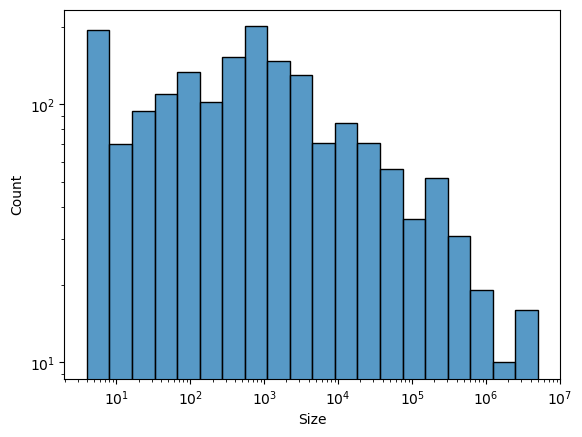

In [22]:
sns.histplot(data=df_sizes,x="Size", log_scale=(True, True))